#### 基元中的混沌共振
ref: G. Wang, et al. Chaotic resonance in izhikevich neural network motifs under electromagnetic induction, Nonlinear Dyn. 107 (2022) 3945–3962. 

model: izhikevich model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import random
from joblib import Parallel, delayed
from tqdm import tqdm
from numba import njit, prange

In [2]:
# 固定种子
seed = 0
np.random.seed(seed)
random.seed(seed)

#### 模型

In [3]:
@njit
def Euler(fun, x0, t, dt, *args):
    """
    使用 euler 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return: 
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    # 计算下一个时间单位的状态变量
    x0 += dt * fun(x0, t, *args)
    return x0

@njit
def Iz_model(vars, t, I, a, b, k1, k2, k3, alpha, beta):
    res = np.zeros_like(vars)
    
    # 状态变量
    V, u, phi = vars

    dV_dt = 0.04 * V * V + 5 * V - u + 140 - k1*(alpha + 3*beta*phi*phi)*V + I[0]
    du_dt = a * (b * V - u) + I[1]
    dphi_dt = k2 * V - k3 * phi + I[2]

    # 输出结果
    res[0] = dV_dt
    res[1] = du_dt
    res[2] = dphi_dt

    return res

@njit
def spikes_eval_Iz(var, t, thresh, flaglaunch, firingTime, c, d):
    """
        计算神经元是否发放脉冲
    """
    flaglaunch[:] = 0                                   # 重置放电开启标志
    firing_StartPlace = np.where(var[0] > thresh)
    flaglaunch[firing_StartPlace] = 1                   # 放电开启标志
    firingTime[firing_StartPlace] = t                   # 记录放电时间

    var[0] = var[0] * (1 - flaglaunch) + flaglaunch * c
    var[1] += flaglaunch * d

#### 混沌模型

In [4]:
@njit
def Lorenz_model(vars, t):
    res = np.zeros_like(vars)

    # 常数参数
    sigma, rho, beta = 10., 28., 8./3.

    # 状态变量
    x, y, z = vars

    # 变量的导数
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z

    # 输出结果
    res[0] = dx_dt
    res[1] = dy_dt
    res[2] = dz_dt

    return res

#### 突触模型

In [5]:
@njit
def dr_dt(r, t, vars):
    dr_dt = (1-r)/(1+np.exp(-vars)) - r/10.
    return dr_dt

@njit
def syn_chem_ds(vars, r, e, pre_ids, post_ids, w, t, dt, vars_d):
    # 计算突触电流贡献
    currents = w * (e[pre_ids] - vars[post_ids]) * r[pre_ids]

    # 神经元数量
    num_neurons = len(vars)  # 突触后神经元总数

    # 累积电流贡献到突触后神经元
    Isyn = np.bincount(post_ids, weights=currents, minlength=num_neurons)

    # 更新突触后神经元的状态变量
    Euler(dr_dt, r, t, dt, vars_d)

    return Isyn

#### 延迟器

In [6]:
@njit
def delay(x, k, delayLong, delay):
    """
        x: 输入的延迟变量
        k: 指针位置
        delayLong: 延迟时长
        delay: 延迟存储矩阵
    """
    # 计算延迟位置索引
    delayed_k = (k - delayLong) % (delayLong+1)

    # 输出延迟值
    delay_o = delay[:, delayed_k].copy() 
    k = (k + 1) % (delayLong+1)             # 前进指针
    delay[:, k] = x

    return delay_o, k

In [7]:
@njit
def net(epli_chaos, omega_weak, g_syn):
    # ============ 设置节点参数 ============ 
    nodes_exc = np.array([0, 1, 2], dtype=np.int8)   # 兴奋性神经元
    # nodes_exc = np.empty(0, dtype=np.int8)   # 兴奋性神经元(没有时使用空数组)
    # nodes_inh = np.array([2], dtype=np.int8)   # 抑制性神经元
    nodes_inh = np.empty(0, dtype=np.int8)   # 抑制性神经元(没有时使用空数组)
    
    a = np.zeros(3)  # a参数
    b = np.zeros(3)  # b参数
    c = np.zeros(3)  # c参数
    d = np.zeros(3)  # d参数
    # 兴奋性神经元
    a[nodes_exc] = 0.02
    b[nodes_exc] = 0.2
    c[nodes_exc] = -65
    d[nodes_exc] = 8
    # 抑制性神经元
    a[nodes_inh] = 0.1
    b[nodes_inh] = 0.2
    c[nodes_inh] = -65
    d[nodes_inh] = 2

    thresh = 30  # 放电阈值
    flaglaunch = np.zeros(3, dtype=np.int8)  # 放电开启标志
    firingTime = np.zeros(3)  # 放电时间
    
    k1 = 0.01
    k2 = 0.01
    k3 = 0.2
    alpha = 0.4
    beta = 0.02

    # 状态变量初始化
    v = 0.3*np.ones(3)                  # 膜电位
    u = 0.2*np.ones(3)                  # 恢复变量
    phi = 0.1*np.ones(3)                # 磁通量
    vars_nodes = np.vstack((v, u, phi))  # 状态变量矩阵

    N_vars = 3  # 变量的数量

    # ============ 混沌信号状态变量初始化 ============ 
    x0_chaos = -0.1*np.ones(1)
    y0_chaos = 0.1*np.ones(1)
    z0_chaos = 0.3*np.ones(1)
    vars_nodes_chaos = np.vstack((x0_chaos, y0_chaos, z0_chaos))  # 混沌状态变量矩阵

    # ============ 突触参数 ============
    # 突触连接矩阵
    A = np.array([[0, 0, 0],
                  [1, 0, 0],
                  [1, 0, 1]], dtype=np.int8)
    # 突触连接矩阵的稀疏表示
    # A_sparse = coo_matrix(A)
    # post_ids = A_sparse.row   # 突触后神经元的索引
    # pre_ids = A_sparse.col    # 突触前神经元的索引
    post_ids, pre_ids = np.nonzero(A)
    # print(pre_ids, post_ids)
 
    # g_syn = 0.02                 # 突触强度
    e_syn = np.zeros(3)         # 突触前神经元的平衡电位
    e_syn[nodes_exc] = 0.       # 兴奋性神经元的平衡电位
    e_syn[nodes_inh] = -80.     # 抑制性神经元的平衡电位

    r_syn = 0.1*np.ones(3)  # 与突触相关的变量

    # 突触延迟参数
    Tn_d = 10_00                         # 延迟时长
    delay_m = np.zeros((3, Tn_d+1))      # 延迟存储矩阵
    k_d = 0                              # 延迟指针

    # ============ 运行部分 ============
    # 时间参数
    dt = 0.01  # 时间步长
    t = 0.  # 初始时间

    # 初始化
    for _ in range(1000_00):
        # 时间延迟
        vars_nodes_d, k_d = delay(vars_nodes[0], k_d, Tn_d, delay_m)

        I = np.zeros((N_vars, 3))
        Euler(Iz_model, vars_nodes, t, dt, I, a, b, k1, k2, k3, alpha, beta)
        spikes_eval_Iz(vars_nodes, t, thresh, flaglaunch, firingTime, c, d)

        Euler(Lorenz_model, vars_nodes_chaos, t, dt)    # 混沌信号

    # 弱信号
    A_weak = 2.
    # omega_weak = 0.15

    # epli_chaos = 0.1  # 混沌信号的扰动

    for _ in range(1000_00):
        # 时间延迟
        vars_nodes_d, k_d = delay(vars_nodes[0], k_d, Tn_d, delay_m)

        # 突触电流
        I_syn = syn_chem_ds(vars_nodes[0], r_syn, e_syn, pre_ids, post_ids, g_syn, t, dt, vars_nodes_d)

        I = np.zeros((N_vars, 3))
        I[0, 0] += A_weak * np.sin(omega_weak * t)  # 第一个神经元的膜电位上加上
        I[0] += epli_chaos * vars_nodes_chaos[0]    # 混沌信号扰动
        I[0] += I_syn   # 突触电流

        Euler(Iz_model, vars_nodes, t, dt, I, a, b, k1, k2, k3, alpha, beta)
        spikes_eval_Iz(vars_nodes, t, thresh, flaglaunch, firingTime, c, d)

        Euler(Lorenz_model, vars_nodes_chaos, t, dt)    # 混沌信号

        t += dt

    # 统计计算
    Q_sin = 0.
    Q_cos = 0.

    M = 500 # 计算周期
    cal_n = int(2 * np.pi * M / (omega_weak * dt))
    # print(cal_n)
    # mem = []
    for _ in range(cal_n):
        # 时间延迟
        vars_nodes_d, k_d = delay(vars_nodes[0], k_d, Tn_d, delay_m)

        # 突触电流
        I_syn = syn_chem_ds(vars_nodes[0], r_syn, e_syn, pre_ids, post_ids, g_syn, t, dt, vars_nodes_d)

        I = np.zeros((N_vars, 3))
        I[0, 0] += A_weak * np.sin(omega_weak * t)  # 第一个神经元的膜电位上加上
        I[0] += epli_chaos * vars_nodes_chaos[0]    # 混沌信号扰动
        I[0] += I_syn   # 突触电流

        Euler(Iz_model, vars_nodes, t, dt, I, a, b, k1, k2, k3, alpha, beta)
        spikes_eval_Iz(vars_nodes, t, thresh, flaglaunch, firingTime, c, d)

        Euler(Lorenz_model, vars_nodes_chaos, t, dt)    # 混沌信号

        # 计算傅里叶系数
        Q_sin += 2 * vars_nodes[0, 2] * np.sin(omega_weak * t) / cal_n
        Q_cos += 2 * vars_nodes[0, 2] * np.cos(omega_weak * t) / cal_n

        t += dt
        # mem.append(vars_nodes[0].copy())  # 记录膜电位

    Q_ = np.sqrt(Q_sin**2 + Q_cos**2)   # 傅里叶系数

    # print(Q_)

    return Q_

    # return np.array(mem)

In [8]:
@njit(parallel=True)
def Parallel_net(epli_chaos_list, omega_weak, g_syn):
    """
        并行计算网络
    """
    lens = len(epli_chaos_list)
    results = np.zeros(lens)
    for i in prange(lens):
        results[i] = net(epli_chaos_list[i], omega_weak, g_syn)
        
    return results

In [9]:
# epli_chaos = 0.5
# omega_weak = 0.15
# g_syn = 0.9
# mem = net(epli_chaos, omega_weak, g_syn)
# Q = net(epli_chaos, omega_weak, g_syn)
# plt.plot(mem[:, 0])
# plt.show()

In [10]:
epli_chaos_list = np.linspace(0.001, 3.5, 60)
g_syn = 0.9

In [11]:
omega_weak = 0.15
results1 = Parallel_net(epli_chaos_list, omega_weak, g_syn)

In [12]:
omega_weak = 0.09
results2 = Parallel_net(epli_chaos_list, omega_weak, g_syn)

In [13]:
omega_weak = 0.07
results3 = Parallel_net(epli_chaos_list, omega_weak, g_syn)

In [14]:
omega_weak = 0.05
results4 = Parallel_net(epli_chaos_list, omega_weak, g_syn)

In [15]:
omega_weak = 0.03
results5 = Parallel_net(epli_chaos_list, omega_weak, g_syn)

In [16]:
omega_weak = 0.01
results6 = Parallel_net(epli_chaos_list, omega_weak, g_syn)

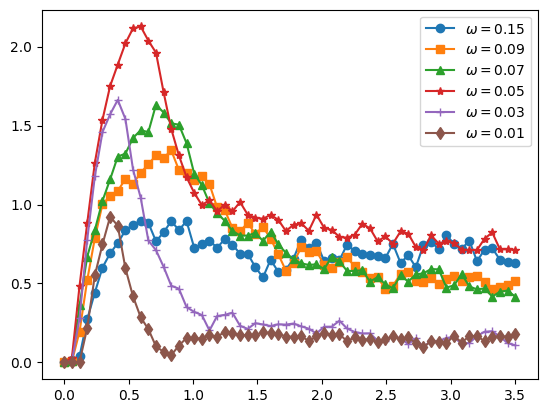

In [17]:
plt.plot(epli_chaos_list, results1, marker='o', label=f"$\omega={0.15}$")
plt.plot(epli_chaos_list, results2, marker='s', label=f"$\omega={0.09}$")
plt.plot(epli_chaos_list, results3, marker='^', label=f"$\omega={0.07}$")
plt.plot(epli_chaos_list, results4, marker='*', label=f"$\omega={0.05}$")
plt.plot(epli_chaos_list, results5, marker='+', label=f"$\omega={0.03}$")
plt.plot(epli_chaos_list, results6, marker='d', label=f"$\omega={0.01}$")

plt.legend()
plt.show()